In [123]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm as nrm


Pre-processing for use in estimating Standardized Streamflow Index
Input data
1. original streamflow timeseries
2. LSTM predicted streamflow timeseries
Processing
1. merge and trasform dataframe structure for input into non-paramteric SSI determination script.

In [124]:
def transform_single_column_usgs(input_file_path, output_file_path):
    # Read CSV with datetime as index
    df = pd.read_csv(input_file_path, index_col=0)

    # Reset index to get datetime as column
    df = df.reset_index()

    # Rename columns
    datetime_col = df.columns[0]
    value_col = df.columns[1]

    # Extract site number (remove 'USGS-' prefix if exists)
    site_no = value_col.replace('USGS-', '')  # e.g., "06221400"

    # Parse datetime
    df['datetime'] = pd.to_datetime(df[datetime_col], utc=True)
    df['datetime'] = df['datetime'].dt.tz_localize(None)  # Remove timezone

    # Extract date components
    df['Date'] = df['datetime'].dt.date
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year

    # Add other required columns
    df['agency_cd'] = 'USGS'
    df['site_no'] = site_no
    df['Discharge (cubic feet per second)'] = df[value_col]
    df['X_00060_00003_cd'] = None  # No code info available

    # Select and reorder columns
    final_df = df[['agency_cd', 'site_no', 'Date', 'Day', 'Month', 'Year',
                   'Discharge (cubic feet per second)', 'X_00060_00003_cd']]

    # Save output
    final_df.to_csv(output_file_path, index=False)
    print(f" Transformed CSV saved to: {output_file_path}")
    return final_df

#change directory to input, output folder and csv location
transformed_data_observed = transform_single_column_usgs(
    '9107000.csv', #original streamflow data for taylor gage
    '9107000MOD.csv'
)

print(transformed_data_observed.head())


 Transformed CSV saved to: 9107000MOD.csv
  agency_cd   site_no        Date  Day  Month  Year  \
0      USGS  09107000  1987-10-01    1     10  1987   
1      USGS  09107000  1987-10-02    2     10  1987   
2      USGS  09107000  1987-10-03    3     10  1987   
3      USGS  09107000  1987-10-04    4     10  1987   
4      USGS  09107000  1987-10-05    5     10  1987   

   Discharge (cubic feet per second) X_00060_00003_cd  
0                           1.812278             None  
1                           1.727328             None  
2                           1.727328             None  
3                           1.670694             None  
4                           1.642377             None  


In [125]:
def transform_single_column_usgs(input_file_path, output_file_path):

    df = pd.read_csv(input_file_path, index_col=0)
    df = df.reset_index()
    datetime_col = df.columns[0]
    value_col = df.columns[1]

    # Extract site number (remove 'USGS-' prefix if exists)
    site_no = value_col.replace('USGS-', '')

    # Parse datetime
    df['datetime'] = pd.to_datetime(df[datetime_col], utc=True)
    df['datetime'] = df['datetime'].dt.tz_localize(None)  # Remove timezone

    # Extract date components
    df['Date'] = df['datetime'].dt.date
    df['Day'] = df['datetime'].dt.day
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year

    # Add other required columns
    df['agency_cd'] = 'USGS'
    df['site_no'] = site_no
    df['Discharge (cubic feet per second)'] = df[value_col]
    df['X_00060_00003_cd'] = None  # No code info available

    # Select and reorder columns
    final_df = df[['agency_cd', 'site_no', 'Date', 'Day', 'Month', 'Year',
                   'Discharge (cubic feet per second)', 'X_00060_00003_cd']]

    # Save output
    final_df.to_csv(output_file_path, index=False)
    print(f"Transformed CSV saved to: {output_file_path}")
    return final_df

#change directory to input, output folder and csv location
transformed_data_simulated = transform_single_column_usgs(
    '9107000_predicted_streamflow_data_LSTM_final.csv',
    '9107000_predicted_streamflow_data_LSTM_final_transformerMOD.csv'
)

# Preview
print(transformed_data_simulated.head())


Transformed CSV saved to: 9107000_predicted_streamflow_data_LSTM_final_transformerMOD.csv
  agency_cd   site_no        Date  Day  Month  Year  \
0      USGS  09107000  2020-01-01    1      1  2020   
1      USGS  09107000  2020-01-02    2      1  2020   
2      USGS  09107000  2020-01-03    3      1  2020   
3      USGS  09107000  2020-01-04    4      1  2020   
4      USGS  09107000  2020-01-05    5      1  2020   

   Discharge (cubic feet per second) X_00060_00003_cd  
0                           0.906860             None  
1                           0.871215             None  
2                           0.944498             None  
3                           0.942411             None  
4                           1.003426             None  


In [126]:
transformed_data_observed['Date'] = pd.to_datetime(transformed_data_observed['Date'])
transformed_data_simulated['Date'] = pd.to_datetime(transformed_data_simulated['Date'])

sim_start_date = transformed_data_simulated['Date'].min()
df_observed_until_sim = transformed_data_observed[transformed_data_observed['Date'] < sim_start_date]
df_combined = pd.concat([df_observed_until_sim, transformed_data_simulated], ignore_index=True)

#sort by date just in case
df_combined = df_combined.sort_values('Date').reset_index(drop=True)

# Save and/or return the result
#df_combined.to_csv('combined_observed_simulated.csv', index=False)
print(df_combined.head(), df_combined.tail())


  agency_cd   site_no       Date  Day  Month  Year  \
0      USGS  09107000 1987-10-01    1     10  1987   
1      USGS  09107000 1987-10-02    2     10  1987   
2      USGS  09107000 1987-10-03    3     10  1987   
3      USGS  09107000 1987-10-04    4     10  1987   
4      USGS  09107000 1987-10-05    5     10  1987   

   Discharge (cubic feet per second) X_00060_00003_cd  
0                           1.812278             None  
1                           1.727328             None  
2                           1.727328             None  
3                           1.670694             None  
4                           1.642377             None         agency_cd   site_no       Date  Day  Month  Year  \
13236      USGS  09107000 2023-12-27   27     12  2023   
13237      USGS  09107000 2023-12-28   28     12  2023   
13238      USGS  09107000 2023-12-29   29     12  2023   
13239      USGS  09107000 2023-12-30   30     12  2023   
13240      USGS  09107000 2023-12-31   31     12 

In [127]:
# Recreate time_series with proper datetime index
df_combined['Date'] = pd.to_datetime(df_combined['Date'])  # Convert to datetime first

time_series = {}
for station in df_combined['site_no'].unique():
    time_series[station] = df_combined[df_combined['site_no'] == station][['Date', 'Discharge (cubic feet per second)']].set_index('Date')

# Now this should work:
monthly_series = {station: ts['Discharge (cubic feet per second)'].resample('ME').mean() for station, ts in time_series.items()}
monthly_series

{'09107000': Date
 1987-10-31    1.684396
 1987-11-30    1.379030
 1987-12-31    1.167385
 1988-01-31    1.103444
 1988-02-29    1.065299
                 ...   
 2023-08-31    1.780322
 2023-09-30    1.863217
 2023-10-31    1.701478
 2023-11-30    1.220439
 2023-12-31    0.910021
 Freq: ME, Name: Discharge (cubic feet per second), Length: 435, dtype: float64}

Calculate 1-month Standardized Streamflow index (SSI) for the full period (1987 - 2024).

The **Standardized Streamflow Index (SSI)** is a standardized drought index that transforms streamflow observations into normalized variates.

In [128]:
def calculate_standardized_index_monthly(data, scale):
    """
    Calculate a standardized drought index with month-by-month fitting after aggregation.
    Args:
    - data (pd.Series): Time series data (e.g., precipitation, discharge)
    - scale (int): Time scale in months (e.g., 3 for SPI-3, 6 for SPI-6)

    Returns:
    - pd.Series: Standardized index time series
    """
    # Drop NaN values
    data = data.dropna()

    # Aggregate data over the specified scale
    aggregated_data = data.rolling(window=scale, min_periods=scale).sum()

    # Remove NaN values created by the rolling operation
    aggregated_data = aggregated_data.dropna()

    # Create a new series for the standardized index
    standardized_index = pd.Series(index=aggregated_data.index, data=np.nan)

    # Group data by month
    data_grouped = aggregated_data.groupby(aggregated_data.index.month)

    for month, group in data_grouped:
        if len(group) > 0:
            # Sort the aggregated data and compute ECDF
            sorted_data = np.sort(group)
            n = len(sorted_data)
            ecdf = np.arange(1, n+1) / (n + 1)

            # Transform to standard normal distribution (z-scores)
            z_scores = nrm.ppf(ecdf)

            # Assign the calculated z-scores back to the corresponding indices
            for value, z in zip(sorted_data, z_scores):
                standardized_index.loc[aggregated_data == value] = z

    return standardized_index


**Plot 1 month SSI for Taylor Park River**- The shaded region indicates drought conditions with severity levels varying between 0 and -2.
| SSI Range         | Drought Category   | Description                                      | Frequency of occurrence |
|-------------------|--------------------|--------------------------------------------------|--------------------------|
| ≥ -2.0            | Extremely Wet      | Exceptionally high streamflow conditions         | ~2.3%                   |
| 1.0 to 1.49       | Moderately Wet     | Above-normal streamflow conditions               | ~9.2%                   |
| 0.5 to 0.99       | Mildly Wet         | Slightly above-normal streamflow                 | ~15.0%                  |
| -0.49 to 0.49     | Normal             | Near-normal streamflow conditions                | ~38.2%                  |
| -0.99 to -0.5     | Mildly Dry         | Slightly below-normal streamflow                 | ~15.0%                  |
| -1.49 to -1.0     | Moderately Dry     | Below-normal streamflow, early drought indicators| ~9.2%                   |
| -1.99 to -1.5     | Severely Dry       | Significantly reduced streamflow, drought conditions | ~4.4%                |
| ≤ -2.0            | Extremely Dry      | Exceptionally low streamflow, extreme drought    | ~2.3%                   |


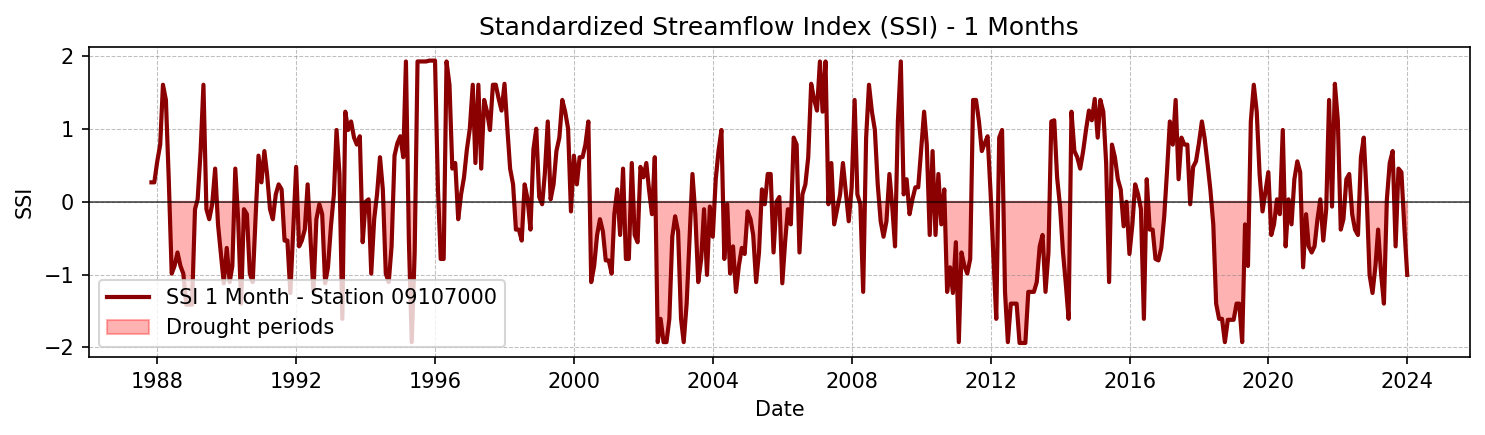

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Specific stations to highlight: This station is located just upstream of Taylor Park Dam
highlight_stations = {'09107000'}

# Create the plot
plt.figure(figsize=(10, 3), dpi=150)

for station_id, data in monthly_series.items():
    discharge_series = data
    ssi1 = calculate_standardized_index_monthly(discharge_series, scale=1)
    
    if station_id in highlight_stations:
        # Plot in bold black for the highlighted stations
        plt.plot(ssi1, label=f'SSI 1 Month - Station {station_id}', color='darkred', linewidth=2)
        
        # Shade areas below 0 for highlighted stations
        plt.fill_between(ssi1.index, ssi1, 0, 
                        where=(ssi1 < 0), 
                        color='red', 
                        alpha=0.3, 
                        interpolate=True,
                        label='Drought periods')
    else:
        # Plot in faint grey for other stations
        plt.plot(ssi1, color='grey', alpha=0.3, linewidth=0.5)

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Add labels and title
plt.title('Standardized Streamflow Index (SSI) - 1 Months')
plt.xlabel('Date')
plt.ylabel('SSI')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
plt.tight_layout()
plt.show()

**Import reservoir data**, check missing and clean the dataframe.

This dataset can be accessed for any reservoir from: https://data.usbr.gov/time-series/search?v=1

The expected data format is indicated below:

| Date             | Inflow (cfs) | Storage (af) | Elevation (ft) | Release (cfs) |
|------------------|--------------|---------------|----------------|----------------|
| 08/01/1990 7:00  | 51.89        | 96,699.8      | 9325.2         | 247            |
| 08/02/1990 7:00  | 149.19       | 96,506.8      | 9325.1         | 247            |
| 08/03/1990 7:00  | 101.80       | 96,217.7      | 9324.95        | 247            |
| 08/04/1990 7:00  | 52.90        | 95,832.9      | 9324.75        | 247            |
| 08/05/1990 7:00  | 53.40        | 95,449.0      | 9324.55        | 247            |
| 08/06/1990 7:00  | 102.31       | 95,161.6      | 9324.40        | 247            |
| 08/07/1990 7:00  | 149.20       | 94,970.3      | 9324.30        | 246            |
| 08/08/1990 7:00  | 101.81       | 94,683.7      | 9324.15        | 246            |
| 08/09/1990 7:00  | 101.81       | 94,397.6      | 9324.00        | 246            |



In [130]:

# Load and clean the data
df = pd.read_csv(r'C:\Users\ethio\OneDrive - Florida International University\Documents\Summer 2025\WSH\taylorParkReservoir.csv')

# Clean date column (remove time component)
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Check missing data
print("Missing data count:")
print(df.isnull().sum())

# Handle missing storage data
print(f"\nTotal rows: {len(df)}")
print(f"Missing storage: {df['Storage (af)'].isnull().sum()}")
df_clean = df.dropna(subset=['Storage (af)'])
print(f"Rows after cleaning: {len(df_clean)}")
print(f"Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(df_clean.head(10))

Missing data count:
Date                0
Inflow(cfs)         0
Storage (af)      943
Elevation (ft)      0
Release (cfs)       0
dtype: int64

Total rows: 13485
Missing storage: 943
Rows after cleaning: 12542
Date range: 1990-08-01 to 2024-12-01
           Date  Inflow(cfs)  Storage (af)  Elevation (ft)  Release (cfs)
943  1990-08-01        51.89       96699.8         9325.20          247.0
944  1990-08-02       149.19       96506.8         9325.10          247.0
945  1990-08-03       101.80       96217.7         9324.95          247.0
946  1990-08-04        52.90       95832.9         9324.75          247.0
947  1990-08-05        53.40       95449.0         9324.55          247.0
948  1990-08-06       102.31       95161.6         9324.40          247.0
949  1990-08-07       149.20       94970.3         9324.30          246.0
950  1990-08-08       101.81       94683.7         9324.15          246.0
951  1990-08-09       101.81       94397.6         9324.00          246.0
952  1990-08-

**Develop Monhlty Adaptive Reservoir Operation in a Tabular Format**

1. Process Storage Data: Conversion to monthly reservoir storage

2. EMPIRICAL Factor Derivation from Historical Data: Derive SSI and storage adjustment factors

3. Helper Functions: Used to load operational parameters from your CSV files

4. Main Implementation and Usage 

In [131]:
# STEP 1: Process Storage Data

def process_storage_data(daily_storage_df, full_capacity_af=106250):
    """
    Convert daily storage data to monthly storage percentages
    
    Parameters:
    - daily_storage_df: DataFrame with Date, Storage (af) columns
    - full_capacity_af: Full storage capacity in acre-feet
    
    Returns:
    - DataFrame with monthly storage percentages
    """
    
    print(f" Processing storage data...")
    print(f"   - Full capacity: {full_capacity_af:,} AF")
    
    # Create a copy to avoid SettingWithCopyWarning
    storage_df = daily_storage_df.copy()
    
    # Ensure Date column is datetime
    storage_df['Date'] = pd.to_datetime(storage_df['Date'])
    
    # Calculate storage percentage
    storage_df['Storage_Percent'] = (storage_df['Storage (af)'] / full_capacity_af) * 100
    
    # Convert to monthly averages (using 'ME' instead of deprecated 'M')
    monthly_storage = storage_df.set_index('Date').resample('ME').agg({
        'Storage (af)': 'mean',
        'Storage_Percent': 'mean'
    }).round(2)
    
    # Reset index to have Date as column
    monthly_storage = monthly_storage.reset_index()
    
    print(f"   - Daily records: {len(daily_storage_df):,}")
    print(f"   - Monthly records: {len(monthly_storage):,}")
    print(f"   - Storage range: {monthly_storage['Storage_Percent'].min():.1f}% - {monthly_storage['Storage_Percent'].max():.1f}%")
    
    return monthly_storage


# STEP 2: EMPIRICAL Factor Derivation from Historical Data

def derive_empirical_factors(historical_daily_df, ssi_series, full_capacity_af=106250):
    """
    Derive SSI and storage adjustment factors empirically from historical operations data
    
    This replaces arbitrary mathematical functions with data-driven relationships
    """
    
    print(" DERIVING EMPIRICAL ADJUSTMENT FACTORS FROM HISTORICAL DATA")
    print("   Method: Analyze actual release patterns during different SSI and storage conditions")
    print()
    
    # Prepare historical data
    hist_df = historical_daily_df.copy()
    hist_df['Date'] = pd.to_datetime(hist_df['Date'])
    hist_df['Storage_Percent'] = (hist_df['Storage (af)'] / full_capacity_af) * 100
    hist_df['Year_Month'] = hist_df['Date'].dt.to_period('M')
    
    # Convert to monthly data to match SSI frequency
    monthly_hist = hist_df.groupby('Year_Month').agg({
        'Inflow(cfs)': 'mean',
        'Release (cfs)': 'mean',
        'Storage_Percent': 'mean'
    }).reset_index()
    
    # Merge with SSI data
    ssi_monthly = ssi_series.to_frame('SSI')
    ssi_monthly['Year_Month'] = ssi_monthly.index.to_period('M')
    
    # Merge operations with SSI
    merged_data = pd.merge(monthly_hist, ssi_monthly, on='Year_Month', how='inner')
    
    print(f" Found {len(merged_data)} months of overlapping historical operations and SSI data")
    
    # DEBUG: Analyze merged_data
    print(f"\n MERGED DATA ANALYSIS:")
    print(f"   Total months: {len(merged_data)}")
    print(f"   Date range: {merged_data['Year_Month'].min()} to {merged_data['Year_Month'].max()}")
    print(f"   SSI range: {merged_data['SSI'].min():.2f} to {merged_data['SSI'].max():.2f}")
    print(f"   Release range: {merged_data['Release (cfs)'].min():.1f} to {merged_data['Release (cfs)'].max():.1f}")
    print(f"   Overall mean release: {merged_data['Release (cfs)'].mean():.1f}")
    
    # Check severe drought periods specifically
    severe_periods = merged_data[merged_data['SSI'] <= -1.5]
    print(f"\n   Severe drought periods (SSI ≤ -1.5): {len(severe_periods)} months")
    if len(severe_periods) > 0:
        print(f"   Severe drought avg release: {severe_periods['Release (cfs)'].mean():.1f}")
        print(f"   Overall avg release: {merged_data['Release (cfs)'].mean():.1f}")
        print(f"   Severe drought factor would be: {severe_periods['Release (cfs)'].mean() / merged_data['Release (cfs)'].mean():.3f}")
    
    if len(merged_data) < 24:  # Need at least 2 years of data
        print("  Insufficient overlapping data for empirical derivation")
        print("   Using simplified linear relationships based on operational principles")
        return create_simplified_factors()
    
    # ========== DERIVE SSI ADJUSTMENT FACTORS ==========
    print("\n1. DERIVING SSI ADJUSTMENT FACTORS:")
    
    # Define SSI ranges based on drought classifications
    ssi_bins = [-np.inf, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, np.inf]
    ssi_labels = ['Extreme Drought', 'Severe Drought', 'Moderate Drought', 'Mild Drought', 
                  'Near Normal', 'Mild Wet', 'Moderate Wet', 'Very Wet']
    
    merged_data['SSI_Category'] = pd.cut(merged_data['SSI'], bins=ssi_bins, labels=ssi_labels)
    
    # Calculate release factors relative to overall mean
    overall_mean_release = merged_data['Release (cfs)'].mean()
    ssi_group_stats = merged_data.groupby('SSI_Category', observed=False).agg({
        'Release (cfs)': ['mean', 'count'],
        'SSI': 'mean'
    }).round(3)
    
    ssi_group_stats.columns = ['Avg_Release', 'Count', 'Avg_SSI']
    ssi_group_stats['Release_Factor'] = ssi_group_stats['Avg_Release'] / overall_mean_release
    
    print("   Empirical SSI-Release Relationship:")
    print("   SSI Category        Avg SSI  Avg Release  Count  Factor")
    print("   " + "-" * 55)
    
    ssi_factor_points = {}
    for category in ssi_group_stats.index:
        if ssi_group_stats.loc[category, 'Count'] >= 3:  # Only use categories with sufficient data
            avg_ssi = ssi_group_stats.loc[category, 'Avg_SSI']
            factor = ssi_group_stats.loc[category, 'Release_Factor']
            count = int(ssi_group_stats.loc[category, 'Count'])
            avg_release = ssi_group_stats.loc[category, 'Avg_Release']
            
            print(f"   {category:15s}   {avg_ssi:6.2f}   {avg_release:8.1f}    {count:3d}   {factor:.3f}")
            ssi_factor_points[avg_ssi] = factor
    
    print(f"\n🔍 DEBUG: SSI Factor Points Found: {ssi_factor_points}")
    
    # ========== DERIVE STORAGE ADJUSTMENT FACTORS ==========
    print("\n2. DERIVING STORAGE ADJUSTMENT FACTORS:")
    
    # Define storage ranges
    storage_bins = [0, 40, 50, 65, 80, 90, 100]
    storage_labels = ['Very Low', 'Low', 'Moderate', 'Good', 'High', 'Very High']
    
    merged_data['Storage_Category'] = pd.cut(merged_data['Storage_Percent'], 
                                           bins=storage_bins, labels=storage_labels)
    
    storage_group_stats = merged_data.groupby('Storage_Category', observed=False).agg({
        'Release (cfs)': ['mean', 'count'],
        'Storage_Percent': 'mean'
    }).round(3)
    
    storage_group_stats.columns = ['Avg_Release', 'Count', 'Avg_Storage']
    storage_group_stats['Release_Factor'] = storage_group_stats['Avg_Release'] / overall_mean_release
    
    print("   Empirical Storage-Release Relationship:")
    print("   Storage Category    Avg Storage%  Avg Release  Count  Factor")
    print("   " + "-" * 58)
    
    storage_factor_points = {}
    for category in storage_group_stats.index:
        if storage_group_stats.loc[category, 'Count'] >= 3:  # Only use categories with sufficient data
            avg_storage = storage_group_stats.loc[category, 'Avg_Storage']
            factor = storage_group_stats.loc[category, 'Release_Factor']
            count = int(storage_group_stats.loc[category, 'Count'])
            avg_release = storage_group_stats.loc[category, 'Avg_Release']
            
            print(f"   {category:15s}        {avg_storage:6.1f}       {avg_release:8.1f}    {count:3d}   {factor:.3f}")
            storage_factor_points[avg_storage] = factor



    def empirical_ssi_factor(ssi_value):
        if len(ssi_factor_points) < 2:
            return np.clip(1.0 + 0.05 * ssi_value, 0.7, 1.3)
        
        # Force monotonic relationship: more negative SSI → lower factors
        ssi_keys = sorted(ssi_factor_points.keys())
        factor_values = [ssi_factor_points[ssi] for ssi in ssi_keys]
        
        # Create monotonic factor values
        monotonic_factors = []
        min_factor = 0.6
        max_factor = 1.5
        
        for i, ssi_key in enumerate(ssi_keys):
            # Force decreasing factors for more negative SSI
            if ssi_key <= 0:  # Drought conditions
                factor = max_factor - (abs(ssi_key) / 2.0) * (max_factor - min_factor)
                factor = max(min_factor, min(max_factor, factor))
            else:  # Wet conditions - use empirical
                factor = factor_values[i]
            monotonic_factors.append(factor)
        
        # Now interpolate with monotonic values
        factor = np.interp(ssi_value, ssi_keys, monotonic_factors)
        
        print(f"🔧 MONOTONIC: SSI={ssi_value:.3f} → factor={factor:.3f}")
        
        return np.clip(factor, 0.5, 1.5)


        ssi_keys = sorted(ssi_factor_points.keys())
        factor_values = [ssi_factor_points[ssi] for ssi in ssi_keys]
        
        # Linear interpolation between empirical points
        factor = np.interp(ssi_value, ssi_keys, factor_values)
        
        # SANITY CHECK: Drought conditions should reduce releases
        if ssi_value < -0.5 and factor > 1.0:
            print(f"  SANITY CHECK FAILED: SSI={ssi_value:.3f} gave factor={factor:.3f}")
            print(f"   Available points: {dict(zip(ssi_keys, factor_values))}")
            print(f"   Forcing drought conditions to reduce releases")
            # Use logical drought response instead
            if ssi_value <= -1.5:  # Severe drought
                factor = 0.65
            elif ssi_value <= -1.0:  # Moderate drought  
                factor = 0.8
            else:  # Mild drought
                factor = 0.9
            print(f"   Corrected factor: {factor:.3f}")
        
        final_factor = np.clip(factor, 0.5, 1.5)
        return final_factor
    
    def empirical_storage_factor(storage_percent):
        """Empirically-derived storage adjustment factor"""
        if len(storage_factor_points) < 2:
            # Fallback: simple linear relationship
            return np.clip(0.85 + (storage_percent / 100.0) * 0.3, 0.7, 1.3)
        
        storage_keys = sorted(storage_factor_points.keys())
        factor_values = [storage_factor_points[storage] for storage in storage_keys]
        
        # Linear interpolation between empirical points
        factor = np.interp(storage_percent, storage_keys, factor_values)
        return np.clip(factor, 0.6, 1.4)
    
    print(f"\n Empirical factors derived from {len(merged_data)} months of historical data")
    print(f"   - SSI factor points: {len(ssi_factor_points)}")
    print(f"   - Storage factor points: {len(storage_factor_points)}")
    
    return empirical_ssi_factor, empirical_storage_factor

def create_simplified_factors():
    """
    Create simplified factor functions when insufficient empirical data available
    """
    print("   Using simplified linear relationships based on operational principles:")
    print("   - SSI factor: 1.0 + 0.05 * SSI (±2 SSI = ±10% adjustment)")
    print("   - Storage factor: 0.85 + 0.003 * Storage% (0% = 0.85, 100% = 1.15)")
    
    def simplified_ssi_factor(ssi_value):
        """Simple linear SSI factor: ±2 SSI gives ±10% adjustment"""
        return np.clip(1.0 + 0.05 * ssi_value, 0.7, 1.3)
    
    def simplified_storage_factor(storage_percent):
        """Simple linear storage factor"""
        return np.clip(0.85 + (storage_percent / 100.0) * 0.3, 0.7, 1.3)
    
    return simplified_ssi_factor, simplified_storage_factor


# STEP 3: Helper Functions


def load_operational_parameters():
    """Load operational parameters from your CSV files"""
    try:
        zones_df = pd.read_csv('taylor_park_baseline_zones.csv')
        correlations_df = pd.read_csv('taylor_park_baseline_decision_logic.csv') 
        thresholds_df = pd.read_csv('taylor_park_baseline_thresholds.csv')
        
        print(" Operational parameters loaded successfully")
        return zones_df, correlations_df, thresholds_df
        
    except FileNotFoundError as e:
        print(f" CSV file not found: {e}")
        raise

def parse_storage_range(range_str):
    """Parse storage range string like '37-50%' to get min and max values"""
    range_str = range_str.replace('%', '')
    min_val, max_val = map(float, range_str.split('-'))
    return min_val, max_val

def determine_storage_zone(storage_percent, zones_df):
    """Determine which storage zone the current storage falls into"""
    for idx, row in zones_df.iterrows():
        min_storage, max_storage = parse_storage_range(row['Storage_Range_Percent'])
        if min_storage <= storage_percent <= max_storage:
            return row['Zone'], row['Typical_Release_CFS']
    return None, None

def get_correlation_weights(correlations_df):
    """Extract and normalize correlation weights"""
    inflow_corr = float(correlations_df[correlations_df['Factor'] == 'Inflow Level']['Correlation'].iloc[0])
    storage_corr = float(correlations_df[correlations_df['Factor'] == 'Storage Level']['Correlation'].iloc[0])
    
    # Normalize weights so they sum to 1
    total_weight = abs(inflow_corr) + abs(storage_corr)
    w_inflow = abs(inflow_corr) / total_weight
    w_storage = abs(storage_corr) / total_weight
    
    print(f"✅ Correlation weights:")
    print(f"   - Inflow/SSI weight: {w_inflow:.3f} (from correlation: {inflow_corr})")
    print(f"   - Storage weight: {w_storage:.3f} (from correlation: {storage_corr})")
    
    return w_inflow, w_storage

def get_ssi_category(ssi_value):
    """Get SSI drought category for interpretation"""
    if ssi_value >= 1.5:
        return "Very Wet"
    elif ssi_value >= 1.0:
        return "Moderately Wet"
    elif ssi_value >= 0.5:
        return "Mildly Wet"
    elif ssi_value >= -0.49:
        return "Normal"
    elif ssi_value >= -0.99:
        return "Mildly Dry"
    elif ssi_value >= -1.49:
        return "Moderately Dry"
    elif ssi_value >= -1.99:
        return "Severely Dry"
    else:
        return "Extremely Dry"


# STEP 4: Main Empirical Implementation


def calculate_adaptive_releases_empirical(ssi1_series, full_operations_df, full_capacity_af=106250):
    """
    Calculate adaptive reservoir releases using empirically-derived factors
    
    Parameters:
    - ssi1_series: Your SSI pandas Series (monthly, 1987-2023)
    - full_operations_df: Complete operations DataFrame with Date, Inflow(cfs), Storage (af), Release (cfs)
    - full_capacity_af: Full storage capacity in acre-feet
    
    Returns:
    - DataFrame with adaptive release recommendations
    """
    
    print(" Starting empirical adaptive reservoir management calculation...")
    
    # Create a copy to avoid SettingWithCopyWarning and split data into periods
    ops_df = full_operations_df.copy()
    ops_df['Date'] = pd.to_datetime(ops_df['Date'])
    historical_period = ops_df[ops_df['Date'] < '2020-01-01'].copy()
    test_period = ops_df[ops_df['Date'] >= '2020-01-01'].copy()
    
    print(f"   - Historical period for factor derivation: {len(historical_period):,} days")
    print(f"   - Test period for adaptive management: {len(test_period):,} days")
    
    # Step 1: Derive empirical adjustment factors from historical data
    ssi_factor_func, storage_factor_func = derive_empirical_factors(
        historical_period, ssi1_series, full_capacity_af
    )
    
    # Step 2: Process test period storage data
    monthly_storage_df = process_storage_data(test_period[['Date', 'Storage (af)']], full_capacity_af)
    
    # Step 3: Load operational parameters
    zones_df, correlations_df, thresholds_df = load_operational_parameters()
    
    # Step 4: Get correlation weights
    w_inflow, w_storage = get_correlation_weights(correlations_df)
    
    # Step 5: Filter SSI to test period (2020-2023) for analysis
    print("\n Filtering to test period (2020-2023)...")
    ssi_test_period = ssi1_series['2020':'2023']
    
    # Step 6: Prepare storage data for the same period
    monthly_storage_df['Date'] = pd.to_datetime(monthly_storage_df['Date'])
    storage_test_period = monthly_storage_df[
        (monthly_storage_df['Date'] >= '2020-01-01') & 
        (monthly_storage_df['Date'] <= '2023-12-31')
    ].set_index('Date')
    
    print(f"   - SSI test period: {len(ssi_test_period)} months")
    print(f"   - Storage test period: {len(storage_test_period)} months")
    
    # Step 7: Calculate adaptive releases
    print("\n Calculating adaptive releases with empirical factors...")
    results = []
    
    for date in ssi_test_period.index:
        # Find matching storage data (closest date)
        storage_data_point = None
        for storage_date in storage_test_period.index:
            if abs((date - storage_date).days) <= 15:  # Within 15 days
                storage_data_point = storage_test_period.loc[storage_date]
                break
        
        if storage_data_point is not None and not pd.isna(ssi_test_period[date]):
            
            # Get current values
            current_ssi = ssi_test_period[date]
            current_storage_percent = storage_data_point['Storage_Percent']
            
            # Determine storage zone and base release
            zone, base_release = determine_storage_zone(current_storage_percent, zones_df)
            
            if zone is not None:
                # Calculate empirically-derived factors
                ssi_factor = ssi_factor_func(current_ssi)
                storage_factor = storage_factor_func(current_storage_percent)
                
                # Calculate weighted combined factor using actual correlations
                combined_factor = (w_inflow * ssi_factor) + (w_storage * storage_factor)
                
                # Calculate adaptive release
                adaptive_release = base_release * combined_factor
                
                # Get SSI category
                ssi_category = get_ssi_category(current_ssi)
                
                results.append({
                    'Date': date,
                    'Monthly_Storage_Percent': round(current_storage_percent, 1),
                    'Monthly_Storage_AF': round(storage_data_point['Storage (af)'], 0),
                    'Monthly_SSI': round(current_ssi, 3),
                    'SSI_Category': ssi_category,
                    'Storage_Zone': int(zone),
                    'Base_Release_CFS': base_release,
                    'SSI_Factor': round(ssi_factor, 3),
                    'Storage_Factor': round(storage_factor, 3),
                    'Combined_Factor': round(combined_factor, 3),
                    'Adaptive_Release_CFS': round(adaptive_release, 1)
                })
    
    results_df = pd.DataFrame(results)
    print(f" Adaptive releases calculated for {len(results_df)} months")
    
    # Show factor ranges for verification
    if len(results_df) > 0:
        print(f"\n Empirical factor ranges:")
        print(f"   - SSI factors: {results_df['SSI_Factor'].min():.3f} - {results_df['SSI_Factor'].max():.3f}")
        print(f"   - Storage factors: {results_df['Storage_Factor'].min():.3f} - {results_df['Storage_Factor'].max():.3f}")
        print(f"   - Combined factors: {results_df['Combined_Factor'].min():.3f} - {results_df['Combined_Factor'].max():.3f}")
    
    return results_df


# STEP 5: Usage


def run_empirical_adaptive_management(ssi1_series, full_operations_df):
    """
    Run the empirical adaptive management with your complete operations dataset
    
    Parameters:
    - ssi1_series: Your SSI pandas Series
    - full_operations_df: Complete operations data (1990-2024) with Date, Inflow(cfs), Storage (af), Release (cfs)
    """
    
    # Calculate adaptive releases using empirical factors
    adaptive_results = calculate_adaptive_releases_empirical(
        ssi1_series, 
        full_operations_df,
        full_capacity_af=106250
    )
    
    # Display results
    print("\n EMPIRICAL ADAPTIVE RESERVOIR MANAGEMENT RESULTS")
    print("=" * 70)
    print(adaptive_results.head(10))
    
    # Summary statistics
    if len(adaptive_results) > 0:
        print(f"\n SUMMARY STATISTICS")
        print("=" * 30)
        print(f"Average adaptive release: {adaptive_results['Adaptive_Release_CFS'].mean():.1f} CFS")
        print(f"Release range: {adaptive_results['Adaptive_Release_CFS'].min():.1f} - {adaptive_results['Adaptive_Release_CFS'].max():.1f} CFS")
        print(f"Average storage: {adaptive_results['Monthly_Storage_Percent'].mean():.1f}%")
        
        drought_months = adaptive_results[adaptive_results['SSI_Category'].str.contains('Dry')]
        print(f"Drought months: {len(drought_months)} out of {len(adaptive_results)} ({len(drought_months)/len(adaptive_results)*100:.1f}%)")
        
        # Zone distribution
        zone_dist = adaptive_results['Storage_Zone'].value_counts().sort_index()
        print(f"\nStorage zone distribution:")
        for zone, count in zone_dist.items():
            print(f"   Zone {zone}: {count} months ({count/len(adaptive_results)*100:.1f}%)")
    
    # Save results
    adaptive_results.to_csv('adaptive_reservoir_releases_empirical.csv', index=False)
    print(f"\n💾 Results saved to 'adaptive_reservoir_releases_empirical.csv'")
    
    return adaptive_results


In [132]:
# Load complete operations data
full_operations_df =   df_clean # Should have columns: Date, Inflow(cfs), Storage (af), Release (cfs), etc.
ssi1_series = ssi1  # LSTM derived SSI data

# Run the empirical adaptive management
results = run_empirical_adaptive_management(ssi1_series, full_operations_df)


 Starting empirical adaptive reservoir management calculation...
   - Historical period for factor derivation: 10,745 days
   - Test period for adaptive management: 1,797 days
 DERIVING EMPIRICAL ADJUSTMENT FACTORS FROM HISTORICAL DATA
   Method: Analyze actual release patterns during different SSI and storage conditions

 Found 353 months of overlapping historical operations and SSI data

 MERGED DATA ANALYSIS:
   Total months: 353
   Date range: 1990-08 to 2019-12
   SSI range: -1.94 to 1.94
   Release range: 49.1 to 1190.4
   Overall mean release: 192.2

   Severe drought periods (SSI ≤ -1.5): 24 months
   Severe drought avg release: 129.4
   Overall avg release: 192.2
   Severe drought factor would be: 0.673

1. DERIVING SSI ADJUSTMENT FACTORS:
   Empirical SSI-Release Relationship:
   SSI Category        Avg SSI  Avg Release  Count  Factor
   -------------------------------------------------------
   Extreme Drought    -1.77      129.4     24   0.673
   Severe Drought     -1.22   